# The finite difference method: another simple example

### This notebook generalizes a little bit the example presented in the Lecture Notes (section 2.3).

We consider here the differential equation
$$
\left\{
\begin{array}{ll}
-u''(x) + c(x)\, u(x) = f(x) &\hbox{for }x\in (a,b)\\
a_1 u'(a) + a_0 u(a)=\alpha, b_1 u'(b)+b_0 u(b)=\beta
\end{array}
\right.
$$

Depending on the choice one makes for $a_0,a_1,b_0,b_1$, the boundary conditions can thus be of Dirichlet, Neumann or Robin types.

## Numerical approximation

Let consider a regular 1-D grid, with a constant mesh size $h$: $x_i=a+ih$ ($i=0,\ldots,N+1$) with $h=\frac{b-a}{N+1}$.
We consider the two-sided second-order finite difference approximation:
$$
- \frac{u(x-h)-2u(x)+u(x+h)}{h^2} + c(x)\, u(x) = f(x)
$$
and one-sided first-order discretizations for the derivative in the boundary conditions.

This leads to the system
\begin{equation}
\left\{
\begin{array}{l}
-u_{i-1}+2u_i-u_{i+1} + h^2 c(x_i)\, u_i = h^2 f(x_i)   \qquad  i=1,\ldots, N \\
 a_1\, \frac{u_1-u_0}{h} + a_0 u_0 = \alpha,\quad b_1\, \frac{u_{N+1}-u_N}{h} + b_0 u_{N+1} = \beta
 \end{array}
 \right.
\end{equation}
where $u_i$ is the approximation of $u(x_i)$.

This can be written in matrix form: 
$$
 \left(\begin{array}{cccccc}
a_0h-a_1 & a_1 & 0 & \cdots & & 0\\
-1 & 2+h^2 c(x_1) & -1 & & & \vdots\\
0 & -1 & 2 & -1 & & \\
& & \ddots & \ddots & \ddots & \\
\vdots & & & -1 & 2+h^2 c(x_N) & -1\\
0 & & \cdots & 0 & -b_1 & b_1+hb_0
\end{array}\right) 
\left(\begin{array}{c}
u_0\\
u_1\\
\vdots\\
\vdots\\
u_N\\
u_{N+1}
 \end{array}\right)
\,
= \left(\begin{array}{c}
h \, \alpha\\
h^2\, f(x_1)\\
\vdots\\
\vdots\\
h^2\, f(x_N)\\
h\, \beta
\end{array}\right)
$$

In [1]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

In [36]:
#####################################################
# definition of the problem and of the exact solution
#####################################################

a = 0      # left bound
b = 6*pi   # right bound

a_0, a_1 = 1, 0 # boundary condition at the left boundary  (1,0): Dirichlet, (0,1): Neumann, (r,1): Robin
b_0, b_1 = 1, 0 # boundary condition at the right boundary  (1,0): Dirichlet, (0,1): Neumann, (r,1): Robin


def cc(xx):   # definition of the function c(x) 
    #res = 0
    res = cos(xx)
    return res

def ExactSol(xx):   # definition of the continuous exact solution
    # example 1: u(x) = sin(x) exp(-x/8)
    res = sin(xx) * exp(-xx/8)
    # example 2: u(x) = sin(x)
    # res = sin(xx)
    return res

def ExactFirstOrderDerivative(xx):   # definition of the exact first-order derivative (useful for boundary conditions)
    # example 1: u(x) = sin(x) exp(-x/8) --> u'(x) = ( - sin(x) + 8 cos(x)) exp(-x/8) / 8
    res = (-sin(xx)+8*cos(xx)) * exp(-xx/8) / 8
    # example 2: u(x) = sin(x) --> u'(x) = cos(x)
    # res = cos(xx)
    return res

def ExactSecondOrderDerivative(xx):   # definition of the exact second-order derivative
    # example 1: u(x) = sin(x) exp(-x/8) --> u"(x) = -(63 sin(x)+16 cos(x)) exp(-x/8) / 64
    res = - (63*sin(xx)+16*cos(xx)) * exp(-xx/8) / 64
    # example 2: u(x) = sin(x) --> u"(x) = -sin(x)
    # res = -sin(xx)
    return res


In [37]:
########################
# definition of the grid
########################

N = 40 # number of grid points within the domain (i.e. without a and b)

In [38]:
def ExactRightHandSide(xx):      # computation of the exact right-hand side f(x) = -u''(x) + c(x) u(x)
    res = -ExactSecondOrderDerivative(xx) + cc(xx) * ExactSol(xx)
    return res

def FiniteDifferenceApprox(a,b,a0,a1,b0,b1,N):
    # computation of the grid
    h=(b-a)/(N+1)
    h2 = h*h
    x = [a+k*h for k in range(N+2)]  # x goes from a to b, with a regular step h=(b-a)/(N+1)
    # exact solution on the grid
    exact = [ExactSol(x[k]) for k in range(N+2)] 
    # computation of the right-hand side of the linear system
    rhs = np.zeros(N+2)
    rhs[1:N+1] = [h2*ExactRightHandSide(x[k]) for k in range(1,N+1)]
    rhs[0] = h*(a_1*ExactFirstOrderDerivative(x[0]) + a_0*ExactSol(x[0])) # alpha = a_1 u'(a) + a_0 u(a) 
    rhs[N+1] = h*(b_1*ExactFirstOrderDerivative(x[N+1]) + b_0*ExactSol(x[N+1])) # beta = b_1 u'(b) + b_0 u(b) 
    # computation of the matrix of the linear system
    v1 = [2+h2*cc(x[k]) for k in range(N+2)]
    v2 = np.ones(N+1)
    M = np.diag(v1) - np.diag(v2,1) - np.diag(v2,-1)
    M[0][0] = a0*h-a1
    M[0][1] = a1
    M[N+1][N] = -b1
    M[N+1][N+1] = b1 + h*b0
    # resolution
    approx = np.linalg.solve(M, rhs)
    return x, exact, approx


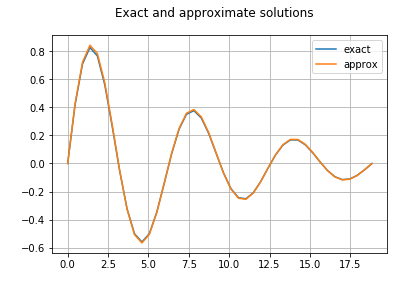

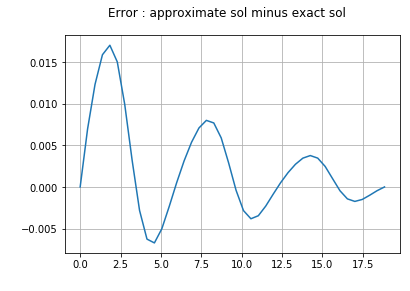

L2 error and Linf Error = (0.026777441691696487, 0.017018513753638276)


In [46]:

x, exact, approx = FiniteDifferenceApprox(a,b,a_0,a_1,b_0,b_1,N)

# plot of the approximate and of the exact solutions
fig, ax = plt.subplots()
ax.plot(x, exact, label='exact')
ax.plot(x, approx, label='approx')
ax.set(xlabel=' ', ylabel=' ')
ax.grid()
ax.legend()
fig.suptitle('Exact and approximate solutions')
#fig.savefig("test.png")
#plt.show()

# plot of the difference
fig, ax = plt.subplots()
ax.plot(x, approx-exact)
ax.set(xlabel=' ', ylabel=' ')
ax.grid()
fig.suptitle('Error : approximate sol minus exact sol')
#fig.savefig("test.png")
plt.show()

def ComputeError(EXACT,APPROX,H):
    L2Error = np.linalg.norm(APPROX - EXACT,2)*sqrt(H)
    LinfError = np.linalg.norm(APPROX - EXACT, np.inf)
    return L2Error,LinfError


print('L2 error and Linf Error =',ComputeError(exact,approx,(b-a)/(N+1)))


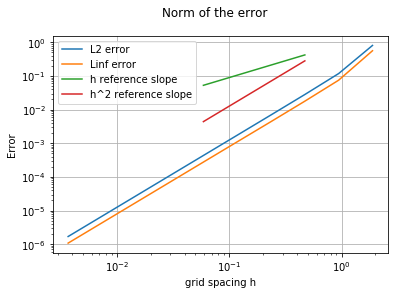

In [40]:
# Illustration of the order of convergence : log-log plot


NbExp = 10  # number of numerical experiments
NbGridPoints = []
NbGridPoints.append(9)   # first simulation: h = (b-a)/10
for k in range(1,NbExp):
    NbGridPoints.append(2*NbGridPoints[k-1]+1)   # next simulation: h --> h/2

Xaxis = np.zeros(NbExp)
ErrorL2 = np.zeros(NbExp)
ErrorLinf = np.zeros(NbExp)

for k in range(NbExp):
    x, exact, approx = FiniteDifferenceApprox(a,b,a_0,a_1,b_0,b_1,NbGridPoints[k])
    h = (b-a)/(NbGridPoints[k]+1)
    ErrorL2[k], ErrorLinf[k] = ComputeError(exact,approx,h)
    Xaxis[k] = h


# reference slopes
i1 = round(NbExp/4)
i2 = round(NbExp/2)
XaxisSlope1 = [Xaxis[i1], Xaxis[i2]] 
ErrorSlope1 = [15*ErrorL2[i1], 15*ErrorL2[i1]*Xaxis[i2]/Xaxis[i1]]

XaxisSlope2 = [Xaxis[i1], Xaxis[i2]] 
ErrorSlope2 = [10*ErrorL2[i1], 10*ErrorL2[i1]*Xaxis[i2]**2/Xaxis[i1]**2]

# plot of the difference
fig, ax = plt.subplots()
ax.plot(Xaxis, ErrorL2, label='L2 error')
ax.plot(Xaxis, ErrorLinf, label='Linf error')
ax.plot(XaxisSlope1,ErrorSlope1, label='h reference slope')
ax.plot(XaxisSlope2,ErrorSlope2, label='h^2 reference slope')
ax.set(xlabel='grid spacing h', ylabel='Error')
ax.grid()
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
fig.suptitle('Norm of the error')
#fig.savefig("testDir.png")
plt.show()
